# Importing packages

In [159]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ppscore as pps
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from IPython.core.display import Image, display

C:\Users\arthu\AppData\Local\Temp\ipykernel_31376\733952326.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [160]:
from utils.plotting_functions import dual_heat_map, pps_heat_map, scatterplot_pearson

In [161]:
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

In [162]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 18,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow':False,
    'legend.fancybox': True,
    'legend.frameon':True,
}) 

# Objective 

For each sensor group we will:

-  Remove outliers
-  Visualize how the presence of irregularities changes the signal compared to no irregularities
-  Visualize the difference between tangent and curved track sections
-  Analyze the correlation between variables - regression problem

**Output:**

- Clean dataset for feature engineering, selection and model.
- Final conclusions from data analysis

# Importing dataset - variables of the real IRV

In [163]:
df = pd.read_csv("Processed_data/FRA3-FRA6.csv.zip") # Dataset from the notebook "preprocessing"
df.columns

Index(['Distance', 'Curvature', 'SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR',
       'UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL', 'TA_X', 'TA_Y', 'TA_Z',
       'Trail_right_y_sec_susp', 'Lead_left_y_sec_susp',
       'Trail_left_y_sec_susp', 'Lead_right_y_sec_susp',
       'Lead_y_accel_right_side', 'Lead_y_accel_left_side',
       'Trail_y_accel_right_side', 'Trail_y_accel_left_side',
       'Lead_z_accel_right_bolster', 'Lead_z_accel_left_bolster',
       'Trail_z_accel_right_bolster', 'Trail_z_accel_left_bolster',
       'Lead_y_accel_right_bolster', 'Lead_y_accel_left_bolster',
       'Trail_y_accel_right_bolster', 'Trail_y_accel_left_bolster',
       'Lead_right_z_prim_susp', 'Lead_left_z_prim_susp',
       'Trail_right_z_prim_susp', 'Trail_left_z_prim_susp',
       'Lead_right_y_prim_susp', 'Lead_left_y_prim_susp',
       'Trail_right_y_prim_susp', 'Trail_left_y_prim_susp',
       'Lead_y_accel_right_axlebox', 'Lead_y_accel_left_axlebox',
       'Trail_y_accel_right_axlebox ', 'Tra

Although the dataset contain both real and virtual sensors, the scope of this notebook will be on the **real** sensors and for **vertical** irregularities

In [ ]:
# real_columns = ['Distance','Curvature',
#                'Trail_right_z_sec_susp','Lead_left_z_sec_susp','Trail_left_z_sec_susp','Lead_right_z_sec_susp',
#                'Triaxial_x','Triaxial_y','Triaxial_z', 
#                'Lead_z_accel_right_side','Lead_z_accel_left_side', 'Trail_z_accel_right_side','Trail_z_accel_left_side',
#                'Lat_irreg_right_rail','Vert_irreg_right_rail','Lat_irreg_left_rail','Vert_irreg_left_rail',
#                'Class', 'Type of segment', 'Segment', 'Radius', 'Radius class']

real_columns = ['Distance', 'Curvature', 
                'SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR',
                'TA_X', 'TA_Y', 'TA_Z',
                'UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL',
                'Irr_Y_RR', 'Irr_Z_RR', 'Irr_Y_LR','Irr_Z_LR',
                'Class', 'Type of segment', 'Segment', 'Radius','Radius class'
                ]


df = df[real_columns]
df

,Distance,Curvature,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,...,UA_Z_TL,Irr_Y_RR,Irr_Z_RR,Irr_Y_LR,Irr_Z_LR,Class,Type of segment,Segment,Radius,Radius class
0,25.0472,0.000000e+00,2.780000e-12,-1.440000e-12,-3.610000e-12,1.110000e-13,1.120000e-13,9.070000e-14,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,No Irr,Tangent,Tangent 1,0,Tangent
1,25.1552,0.000000e+00,2.830000e-12,-1.500000e-12,-3.610000e-12,1.670000e-13,1.110000e-13,9.100000e-14,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,No Irr,Tangent,Tangent 1,0,Tangent
2,25.2632,0.000000e+00,2.890000e-12,-1.500000e-12,-3.720000e-12,2.220000e-13,1.110000e-13,9.120000e-14,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,No Irr,Tangent,Tangent 1,0,Tangent
3,25.3712,0.000000e+00,2.890000e-12,-1.670000e-12,-3.830000e-12,3.330000e-13,1.100000e-13,9.150000e-14,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,No Irr,Tangent,Tangent 1,0,Tangent
4,25.4792,0.000000e+00,3.000000e-12,-1.720000e-12,-3.830000e-12,3.890000e-13,1.090000e-13,9.170000e-14,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,No Irr,Tangent,Tangent 1,0,Tangent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341755,7406.5220,4.871532e-09,-2.083016e-01,-1.256104e-01,7.520508e-02,8.458109e-02,1.973378e-03,-3.274467e-02,0.000166,0.004698,...,0.002516,0.015544,0.054704,-0.001479,-0.055960,FRA3,Tangent,Tangent 10,0,Tangent
341756,7406.6310,1.542825e-08,-2.087750e-01,-1.208639e-01,8.235806e-02,7.629376e-02,1.977453e-03,-3.165407e-02,-0.000265,0.002599,...,0.008118,0.016812,0.057557,-0.000142,-0.048440,FRA3,Tangent,Tangent 1,0,Tangent
341757,7406.7390,1.991719e-08,-2.089495e-01,-1.164130e-01,9.024455e-02,6.818056e-02,1.978647e-03,-3.059112e-02,-0.000658,0.000248,...,0.014244,0.017643,0.060322,0.001236,-0.040930,FRA3,Tangent,Tangent 1,0,Tangent
341758,7406.8470,1.692783e-08,-2.089699e-01,-1.122639e-01,9.850051e-02,6.059329e-02,1.972528e-03,-2.959474e-02,-0.000988,-0.001389,...,0.017421,0.018069,0.062868,0.002626,-0.033568,FRA3,Tangent,Tangent 1,0,Tangent


In [ ]:
#df.to_csv('Processed_data/FRA3-FRA6_real_var_julia.csv.zip',index=False, compression="zip")

# Functions

In [ ]:
def lineplot_sensors(df, columns, x, n_cols=2, figsize=(30, 40), hue=None,hue_order=None):
    
    n_sensors = len(columns)
    n_rows = np.ceil(n_sensors/n_cols).astype('int')

    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize, tight_layout=True)
    ax = ax.reshape((n_cols*n_rows,))
    iax=0

    for s in columns:
        sns.lineplot(data=df, x=x,y=s,ax=ax[iax],hue=hue,hue_order=hue_order)
        ax[iax].set_xlabel('Distance (m)')
        iax += 1

    return fig,ax

In [ ]:
def boxplot_sensors(df, columns, x=None, n_cols=2, figsize=(30, 40), hue=None, hue_order=None, order=None):

    n_sensors = len(columns)
    n_rows = np.ceil(n_sensors/n_cols).astype('int')

    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize, tight_layout=True)
    ax = ax.reshape((n_cols*n_rows,))
    iax = 0

    for s in columns:
        sns.boxplot(data=df, x=x, y=s,
                    ax=ax[iax], hue=hue, hue_order=hue_order,order=order)
        iax += 1
    
    return fig, ax

# Defining sensor groups

Different sensor groups are defined to allow better comparisons for similar sensors

In [ ]:
# categorical_columns = ['Class','Type of segment','Segment','Radius class','Distance']

# uni_accel = ['Lead_z_accel_right_side','Lead_z_accel_left_side','Trail_z_accel_right_side','Trail_z_accel_left_side']
# susp_sensors = ['Trail_right_z_sec_susp','Lead_left_z_sec_susp','Trail_left_z_sec_susp','Lead_right_z_sec_susp']
# triaxial = ['Triaxial_x','Triaxial_y','Triaxial_z']
# numerical_columns = ['Lead_z_accel_right_side', 'Lead_z_accel_left_side','Trail_z_accel_right_side', 'Trail_z_accel_left_side',
#                      'Trail_right_z_sec_susp', 'Lead_left_z_sec_susp', 'Trail_left_z_sec_susp', 'Lead_right_z_sec_susp',
#                      'Triaxial_x', 'Triaxial_y', 'Triaxial_z']
                     
# cols_irreg = ['Lat_irreg_right_rail','Vert_irreg_right_rail','Lat_irreg_left_rail','Vert_irreg_left_rail']

categorical_columns = ['Class','Type of segment','Segment','Radius class','Distance']

uni_accel = ['UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL']
susp_sensors = ['SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR']
triaxial = ['TA_X', 'TA_Y', 'TA_Z']
numerical_columns = ['UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL',
                     'SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR',
                     'TA_X', 'TA_Y', 'TA_Z']

cols_irreg = ['Irr_Y_RR', 'Irr_Z_RR', 'Irr_Y_LR', 'Irr_Z_LR']

# Plotting irregularities

In [ ]:
import chart_studio
chart_studio.tools.set_credentials_file(username='Pirao', api_key='UjYHSaMIM6wNwthFav8C')
chart_studio.tools.set_config_file(world_readable=True, sharing='public')

In [ ]:
import plotly.express as px
import chart_studio.plotly as pyst

# df_aux = df.loc[(df['Distance'] < 1000) & (df['Distance'] > 500)]

# fig = px.line(df_aux, x="Distance", y=cols_irreg[1], color="Class")

# fig.update_layout(
#     autosize=False,
#     width=1200,
#     height=600)

#fig.show()
#pyst.plot(fig, filename='vert_irreg', auto_open=True)


In [ ]:
import plotly.express as px
import chart_studio.plotly as pyst

# df_aux = df.loc[(df['Distance'] < 800) & (df['Distance'] > 500)]

# fig = px.line(df_aux, x="Distance", y=uni_accel[1], color="Class")

# fig.update_layout(
#     autosize=False,
#     width=1200,
#     height=600)

# fig.show()
# pyst.plot(fig, filename='accel_cols', auto_open=True)

In [ ]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 24,
    'axes.linewidth': 2,
    'axes.titlesize': 34,
    'axes.edgecolor': 'black',
    'axes.labelsize': 26,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'font.family': 'Arial',
    'legend.fontsize': 18,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


In [179]:
porra

,splined Track_x,splined Track_y
0,0.000000,0.000000e+00
1,0.327813,0.000000e+00
2,0.655625,0.000000e+00
3,0.983438,0.000000e+00
4,1.311250,0.000000e+00
...,...,...
25405,8328.080000,-3.238480e-13
25406,8328.410000,2.846860e-13
25407,8328.740000,5.173380e-13
25408,8329.060000,3.741090e-13


Text(0, 0.5, 'Curvature (1/m)')

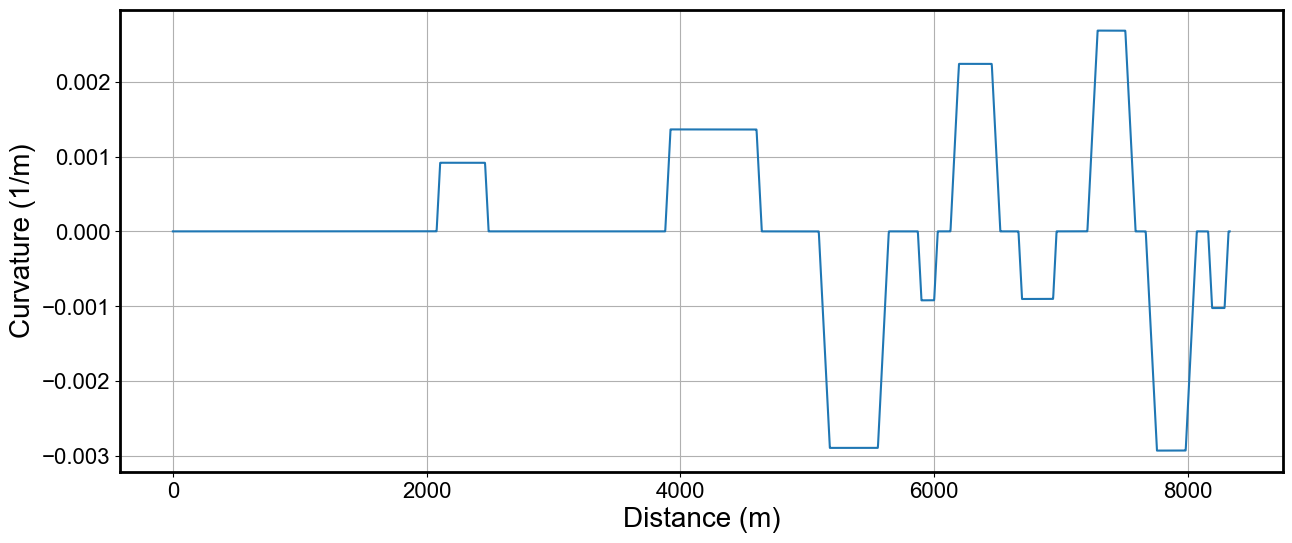

In [180]:
# Dataset from the notebook "preprocessing"
porra = pd.read_excel("Processed_data/curvatura_5152.xlsx")
cols = porra.columns

ax,fig = plt.subplots(1,1,figsize=(15,6))

f = sns.lineplot(data=porra,x=cols[0], y=cols[1])
f.set_xlabel('Distance (m)')
f.set_ylabel('Curvature (1/m)')

(-16.0, 30.0)

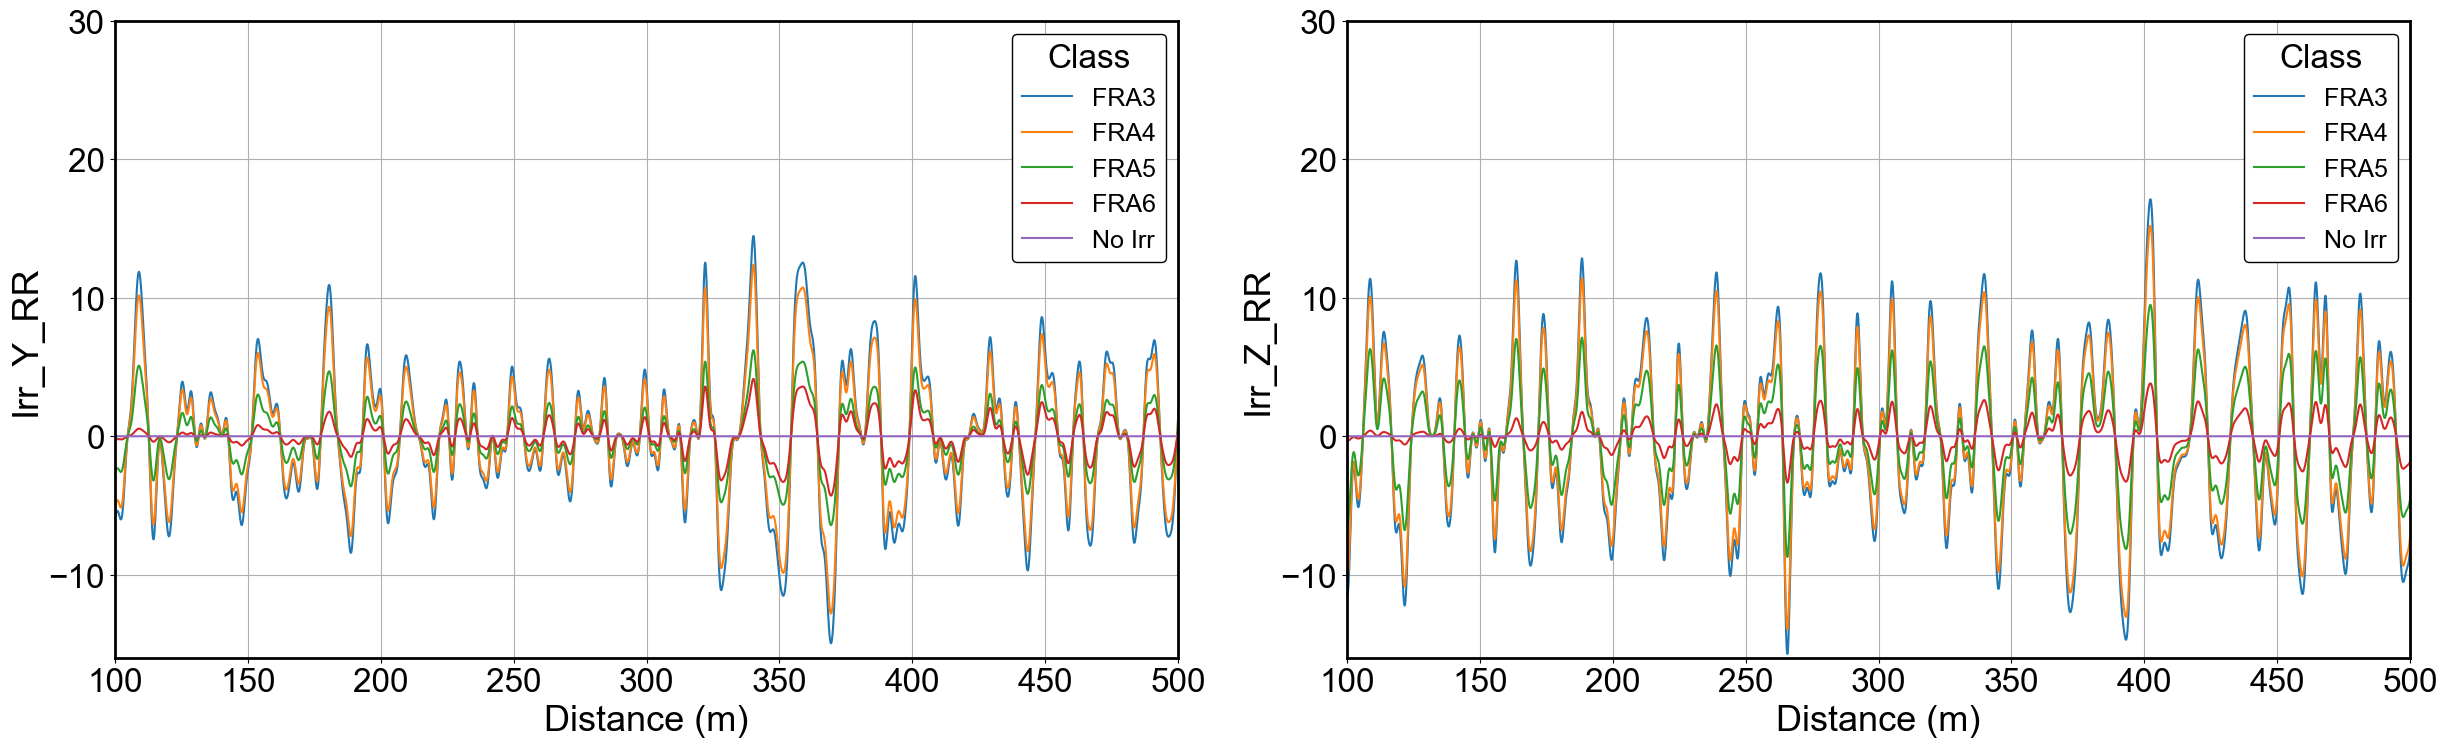

In [ ]:
fig,ax = lineplot_sensors(df, cols_irreg[0:2], 'Distance', n_cols=2, figsize=(25, 8), 
                          hue='Class', hue_order=['FRA3', 'FRA4', 'FRA5', 'FRA6', 'No Irr'])
ax[0].set_xlim([100,500])
ax[1].set_xlim([100,500])
ax[0].set_ylim([-16,30])
ax[1].set_ylim([-16,30])

#ax[2].set_xlim([100,500])
#ax[3].set_xlim([100,500])

# # Save figure
# fig.savefig('Images/All_irregularities.png', dpi=300,bbox_inches='tight', facecolor='white', transparent=False)

All simulated irregularities have the same seed, therefore, they differ only by a scaling factor

# Visualize the presence and cause of outliers

## No irregularities

In [ ]:
# df_filtered = df.loc[(df['Class'] == 'No irregularities')]

# fig,ax = lineplot_sensors(df_filtered, x='Distance',columns=numerical_columns,n_cols=2, figsize=(30, 30), hue='Class')

In [ ]:
# fig, ax = boxplot_sensors(
#     df_filtered, x='Class', columns=numerical_columns, n_cols=4, figsize=(30, 20), hue='Class')

# ax[0].set_ylim([-2,2])
# ax[1].set_ylim([-2,2])
# ax[2].set_ylim([-2,2])
# ax[3].set_ylim([-2,2])

# ax[4].set_ylim([-7,7])
# ax[5].set_ylim([-7,7])
# ax[6].set_ylim([-7,7])
# ax[7].set_ylim([-7,7])

# ax[8].set_ylim([-0.7,0.7])
# ax[9].set_ylim([-0.7,0.7])
# ax[10].set_ylim([-0.7,0.7])

All 4 uniaxial accelerometers and the X and Y components exhibit peaks due to the transition between track segments (tangent to curve or curve to tangent). This is a common occurance during transportation, therefore, the existance of acceleration peaks is normal.

The value of these peaks, however, is an issue that can be discussed. It is possible that peaks of large value is due to numerical error instead of the contact forces. This is likely noise that occured during simulation and should be removed. 

Let us observe if this occurs for other irregularity classes

## FRA6 and FRA3

In [ ]:
df_filtered = df.loc[(df['Class'] == 'FRA6')]

# fig = lineplot_sensors(df_filtered, x='Distance',columns=numerical_columns, n_cols=2, figsize=(30, 40), hue='Class')

<AxesSubplot:xlabel='Distance', ylabel='Curvature'>

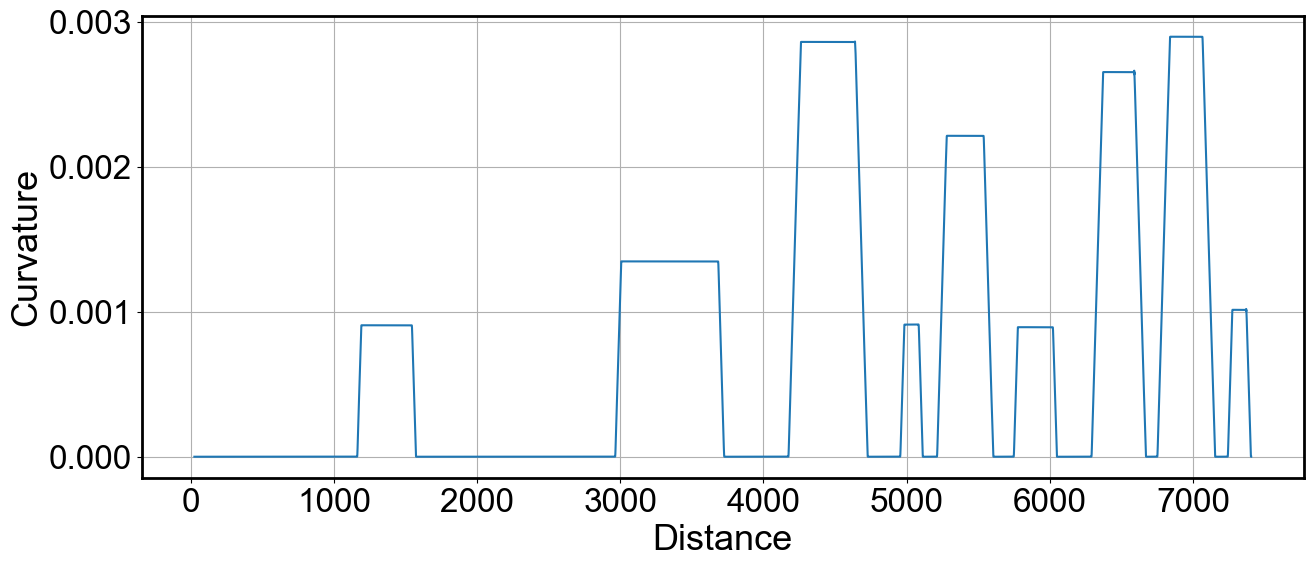

In [ ]:
sns.lineplot(data=df_filtered,x='Distance',y='Curvature')

In [ ]:
# fig,ax = boxplot_sensors(df_filtered, x='Class',columns=numerical_columns,n_cols=4, figsize=(30, 20), hue='Class')

# ax[0].set_ylim([-15,15])
# ax[1].set_ylim([-15,15])
# ax[2].set_ylim([-15,15])
# ax[3].set_ylim([-15,15])

# ax[4].set_ylim([-7,8])
# ax[5].set_ylim([-7,8])
# ax[6].set_ylim([-7,8])
# ax[7].set_ylim([-7,8])

# ax[8].set_ylim([-0.7,0.7])
# ax[9].set_ylim([-0.7,0.7])
# ax[10].set_ylim([-0.7,0.7])

In [ ]:
# df_filtered = df.loc[(df['Class'] == 'FRA3')]

# fig = lineplot_sensors(df_filtered,x='Distance', columns=numerical_columns,n_cols=2, figsize=(30, 40), hue='Class')

In [ ]:
# fig, ax = boxplot_sensors(df_filtered,x='Class', columns=numerical_columns, n_cols=4, figsize=(30, 20), hue='Class')

# ax[0].set_ylim([-380, 320])
# ax[1].set_ylim([-380, 320])
# ax[2].set_ylim([-380, 320])
# ax[3].set_ylim([-380, 320])

# ax[4].set_ylim([-23, 23])
# ax[5].set_ylim([-23, 23])
# ax[6].set_ylim([-23, 23])
# ax[7].set_ylim([-23, 23])

# ax[8].set_ylim([-3, 3.2])
# ax[9].set_ylim([-3, 3.2])
# ax[10].set_ylim([-3, 3.2])

**Conclusions:**: Uniaxial accelerometers have a major outlier problem for **ALL** irregularity classes. 

# Outlier removal - uniaxial accelerometers

For the FRA classes, large acceleration peaks presents are likely due to numerical error since measured data does not reach the same order of magnitude. 

Therefore, only the more prominent peaks will be removed/smoothed in order to maintain the same level of information previous to the filtering. We will do this for each individual FRA class

In [ ]:
df_num = df.drop(categorical_columns, axis=1)
df_cat = df[categorical_columns]

In [ ]:
# from utils.FRA_class import Welch_PSD

# # PSD using Welch's method
# freq, welch_coef = Welch_PSD(df_num[uni_accel[0]], fs=1/0.108)

# plt.plot(freq, welch_coef, label='Target', alpha=0.6)

# plt.xlabel('Spatial frequency (1/m)')
# plt.ylabel('PSD $(m^2/(1/m)$')
# plt.xscale('log')
# plt.yscale('log')

# plt.legend()

In [ ]:
def iqr_remove_outliers(df_num, cols, Q1=0.25, Q2=0.75, k=3):
    Q1 = df_num[cols].quantile(Q1)
    Q3 = df_num[cols].quantile(Q2)
    IQR = Q3 - Q1

    cutoff = k * IQR
    print('Cutoff value:', cutoff)
    idx = ~((df_num[cols] < (Q1 - cutoff)) |
            (df_num[cols] > (Q3 + cutoff))).any(axis=1)
    print(idx.value_counts())

    df_new = df_num.loc[idx]

    return df_new


In [ ]:
#classes = ['FRA5', 'FRA4', 'FRA3']
classes = ['No Irr', 'FRA6','FRA5', 'FRA4', 'FRA3']

df_num_clean = pd.DataFrame()

for item in classes:

    print('Class ', item)
    df_filtered = df_num.loc[(df['Class'] == item)]
    df_clean = iqr_remove_outliers(
    df_num=df_filtered, cols=uni_accel, Q1=0.25, Q2=0.75, k=70)
    df_num_clean = pd.concat([df_num_clean, df_clean], axis=0)
    print('')

Class  No Irr
Cutoff value: UA_Z_LR    0.15561
UA_Z_LL    0.15435
UA_Z_TR    0.15561
UA_Z_TL    0.15435
dtype: float64
True     68285
False       67
dtype: int64

Class  FRA6
Cutoff value: UA_Z_LR    10.152800
UA_Z_LL    10.098375
UA_Z_TR    10.387475
UA_Z_TL    10.326050
dtype: float64
True     68350
False        2
dtype: int64

Class  FRA5
Cutoff value: UA_Z_LR    26.168747
UA_Z_LL    26.199582
UA_Z_TR    26.940760
UA_Z_TL    26.718300
dtype: float64
True     68342
False       10
dtype: int64

Class  FRA4
Cutoff value: UA_Z_LR    44.691605
UA_Z_LL    44.227925
UA_Z_TR    43.981823
UA_Z_TL    43.888845
dtype: float64
True     68155
False      197
dtype: int64

Class  FRA3
Cutoff value: UA_Z_LR    51.502868
UA_Z_LL    51.092475
UA_Z_TR    50.213170
UA_Z_TL    50.238965
dtype: float64
True     67979
False      373
dtype: int64



In [ ]:
df_removed = pd.concat([df_num_clean, df_cat.loc[df_num_clean.index]], axis=1)
df_removed

,Curvature,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,UA_Z_LL,...,Irr_Y_RR,Irr_Z_RR,Irr_Y_LR,Irr_Z_LR,Radius,Class,Type of segment,Segment,Radius class,Distance
0,0.000000e+00,2.780000e-12,-1.440000e-12,-3.610000e-12,1.110000e-13,1.120000e-13,9.070000e-14,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,No Irr,Tangent,Tangent 1,Tangent,25.0472
1,0.000000e+00,2.830000e-12,-1.500000e-12,-3.610000e-12,1.670000e-13,1.110000e-13,9.100000e-14,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,No Irr,Tangent,Tangent 1,Tangent,25.1552
2,0.000000e+00,2.890000e-12,-1.500000e-12,-3.720000e-12,2.220000e-13,1.110000e-13,9.120000e-14,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,No Irr,Tangent,Tangent 1,Tangent,25.2632
3,0.000000e+00,2.890000e-12,-1.670000e-12,-3.830000e-12,3.330000e-13,1.100000e-13,9.150000e-14,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,No Irr,Tangent,Tangent 1,Tangent,25.3712
4,0.000000e+00,3.000000e-12,-1.720000e-12,-3.830000e-12,3.890000e-13,1.090000e-13,9.170000e-14,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,No Irr,Tangent,Tangent 1,Tangent,25.4792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341755,4.871532e-09,-2.083016e-01,-1.256104e-01,7.520508e-02,8.458109e-02,1.973378e-03,-3.274467e-02,0.000166,0.004698,-0.000915,...,0.015544,0.054704,-0.001479,-0.055960,0,FRA3,Tangent,Tangent 10,Tangent,7406.5220
341756,1.542825e-08,-2.087750e-01,-1.208639e-01,8.235806e-02,7.629376e-02,1.977453e-03,-3.165407e-02,-0.000265,0.002599,-0.002653,...,0.016812,0.057557,-0.000142,-0.048440,0,FRA3,Tangent,Tangent 1,Tangent,7406.6310
341757,1.991719e-08,-2.089495e-01,-1.164130e-01,9.024455e-02,6.818056e-02,1.978647e-03,-3.059112e-02,-0.000658,0.000248,-0.004657,...,0.017643,0.060322,0.001236,-0.040930,0,FRA3,Tangent,Tangent 1,Tangent,7406.7390
341758,1.692783e-08,-2.089699e-01,-1.122639e-01,9.850051e-02,6.059329e-02,1.972528e-03,-2.959474e-02,-0.000988,-0.001389,-0.005562,...,0.018069,0.062868,0.002626,-0.033568,0,FRA3,Tangent,Tangent 1,Tangent,7406.8470


Before, the dataset size was 341760 rows × 60 columns. After outlier removal it is 341221 rows × 22 columns

After outlier removal for class FRA3

In [ ]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 25,
    'axes.linewidth': 2,
    'axes.titlesize': 10,
    'axes.edgecolor': 'black',
    'axes.labelsize': 30,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'font.family': 'Arial',
    'legend.fontsize': 18,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow':False,
    'legend.fancybox': True,
    'legend.frameon':True,
})

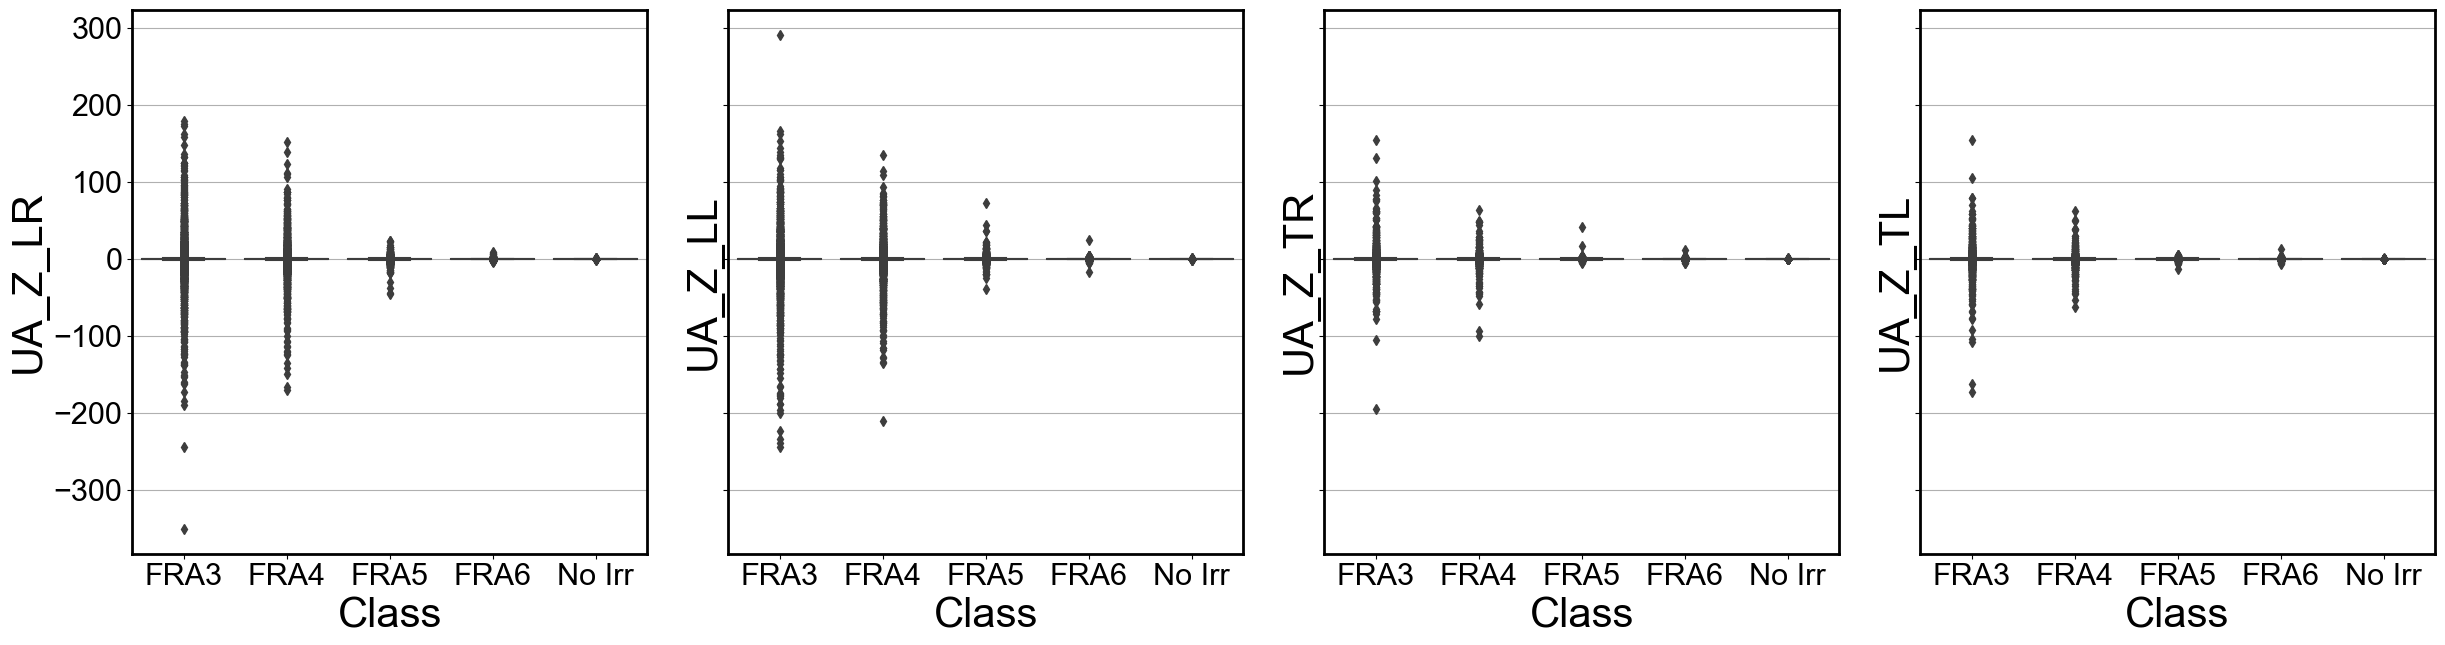

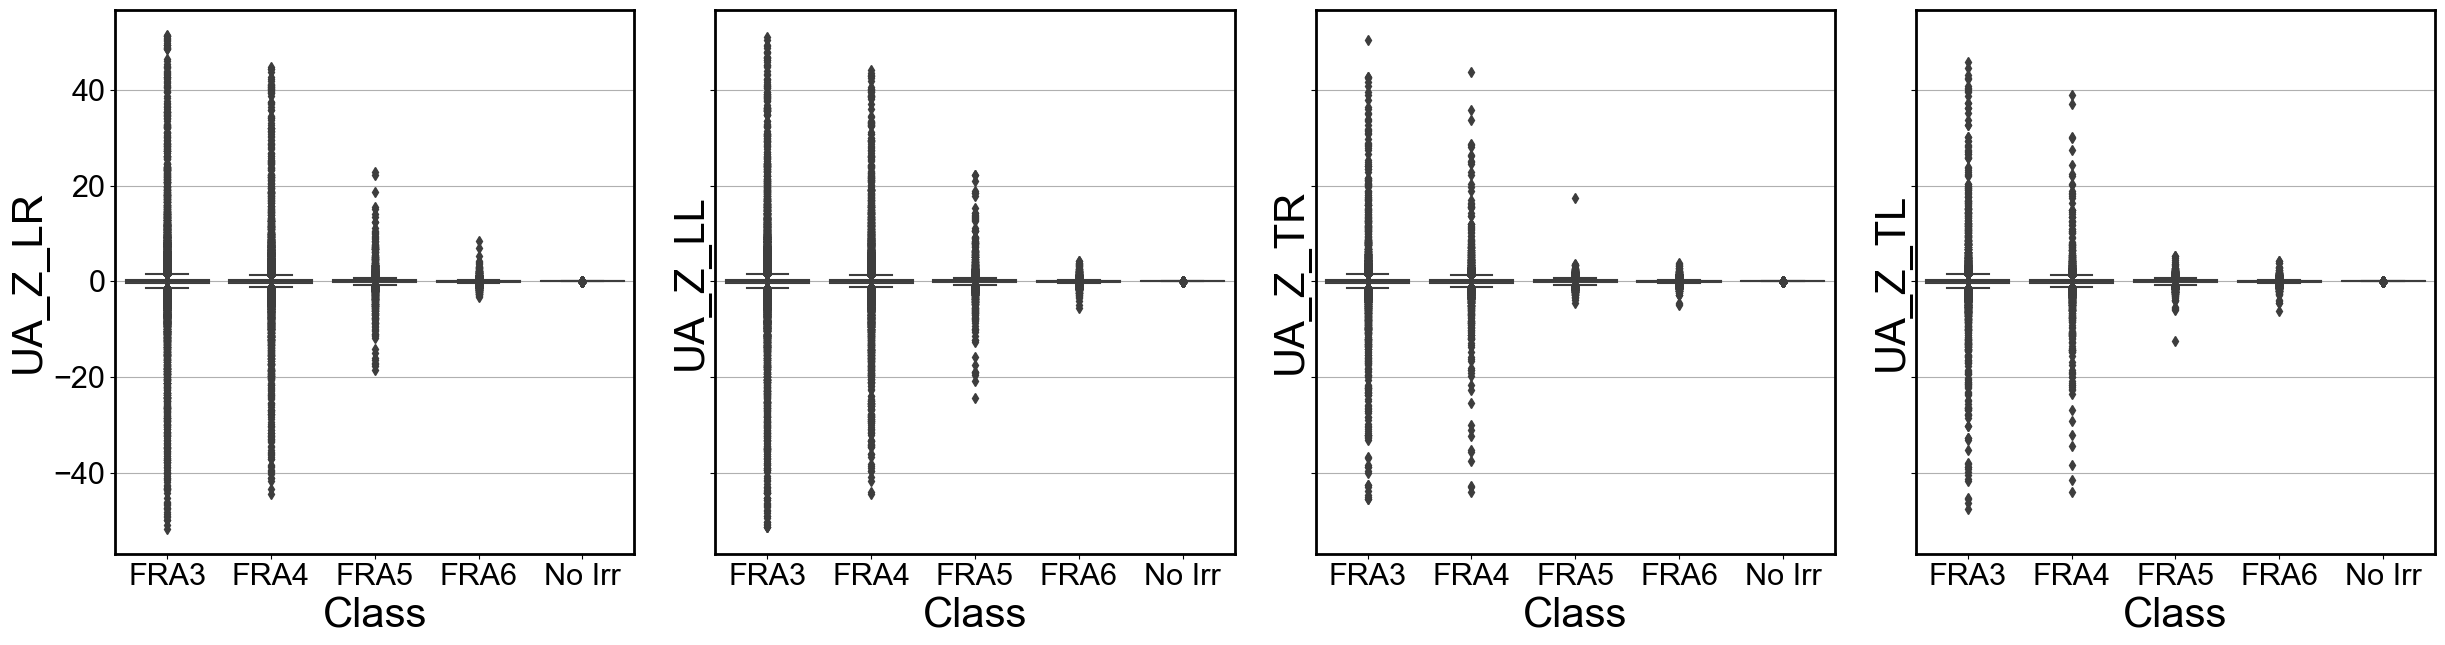

In [ ]:
# cols = ['Lead_z_accel_right_side', 'Lead_z_accel_left_side',
#         'Trail_z_accel_right_side', 'Trail_z_accel_left_side', 'Class']

cols = ['UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL', 'Class']

fig1, ax1 = plt.subplots(1, 4, figsize=(25,7), tight_layout=True,sharey=True)

for idx,sensor in enumerate(uni_accel):
    sns.boxplot(data=df[cols], x='Class', y=sensor, ax=ax1[idx], hue=None, order=['FRA3', 'FRA4', 'FRA5', 'FRA6', 'No Irr'])

fig2, ax2 = plt.subplots(1, 4, figsize=(25, 7), tight_layout=True, sharey=True)

for idx, sensor in enumerate(uni_accel):
    sns.boxplot(data=df_removed[cols], x='Class', y=sensor, ax=ax2[idx], hue=None, order=['FRA3', 'FRA4', 'FRA5', 'FRA6', 'No Irr'])


# sensor = uni_accel[1]
# sns.boxplot(data=df[cols], x='Class', y=sensor, hue=None, order=['FRA3', 'FRA4', 'FRA5', 'FRA6', 'No Irr'])

In [ ]:
categorical_columns = ['Class', 'Type of segment',
                       'Segment', 'Radius class', 'Distance']

uni_accel = ['UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL']
susp_sensors = ['SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR']
triaxial = ['TA_X', 'TA_Y', 'TA_Z']
numerical_columns = ['UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL',
                     'SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR',
                     'TA_X', 'TA_Y', 'TA_Z']

cols_irreg = ['Irr_Y_RR', 'Irr_V_RR', 'Irr_Y_LR', 'Irr_Z_LR']


In [ ]:
# cols = ['Lead_z_accel_right_side','Lead_z_accel_left_side','Trail_z_accel_right_side','Trail_z_accel_left_side','Class']

# fig1, ax1 = plt.subplots(1, 4, figsize=(30,8), tight_layout=True,sharey=True)

# for idx,sensor in enumerate(uni_accel[0:2]):
#     sns.boxplot(data=df[cols], x='Class', y=sensor, ax=ax1[idx], hue=None, order=['FRA3', 'FRA4', 'FRA5', 'FRA6', 'No irregularities'])

# fig2, ax2 = plt.subplots(1, 4, figsize=(30, 8), tight_layout=True, sharey=True)

# for idx, sensor in enumerate(uni_accel[0:2]):
#     sns.boxplot(data=df_removed[cols], x='Class', y=sensor, ax=ax2[idx], hue=None, order=['FRA3', 'FRA4', 'FRA5', 'FRA6', 'No irregularities'])
    
#fig1.savefig('Images/fig_before_outlier_removal.png', dpi=300,bbox_inches='tight', facecolor='white', transparent=False)
#fig2.savefig('Images/fig_after_outlier_removal.png', dpi=300,bbox_inches='tight', facecolor='white', transparent=False)

# Difference between curved and tangent sections

In [ ]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 24,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 25,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'font.family': 'Arial',
    'legend.fontsize': 18,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


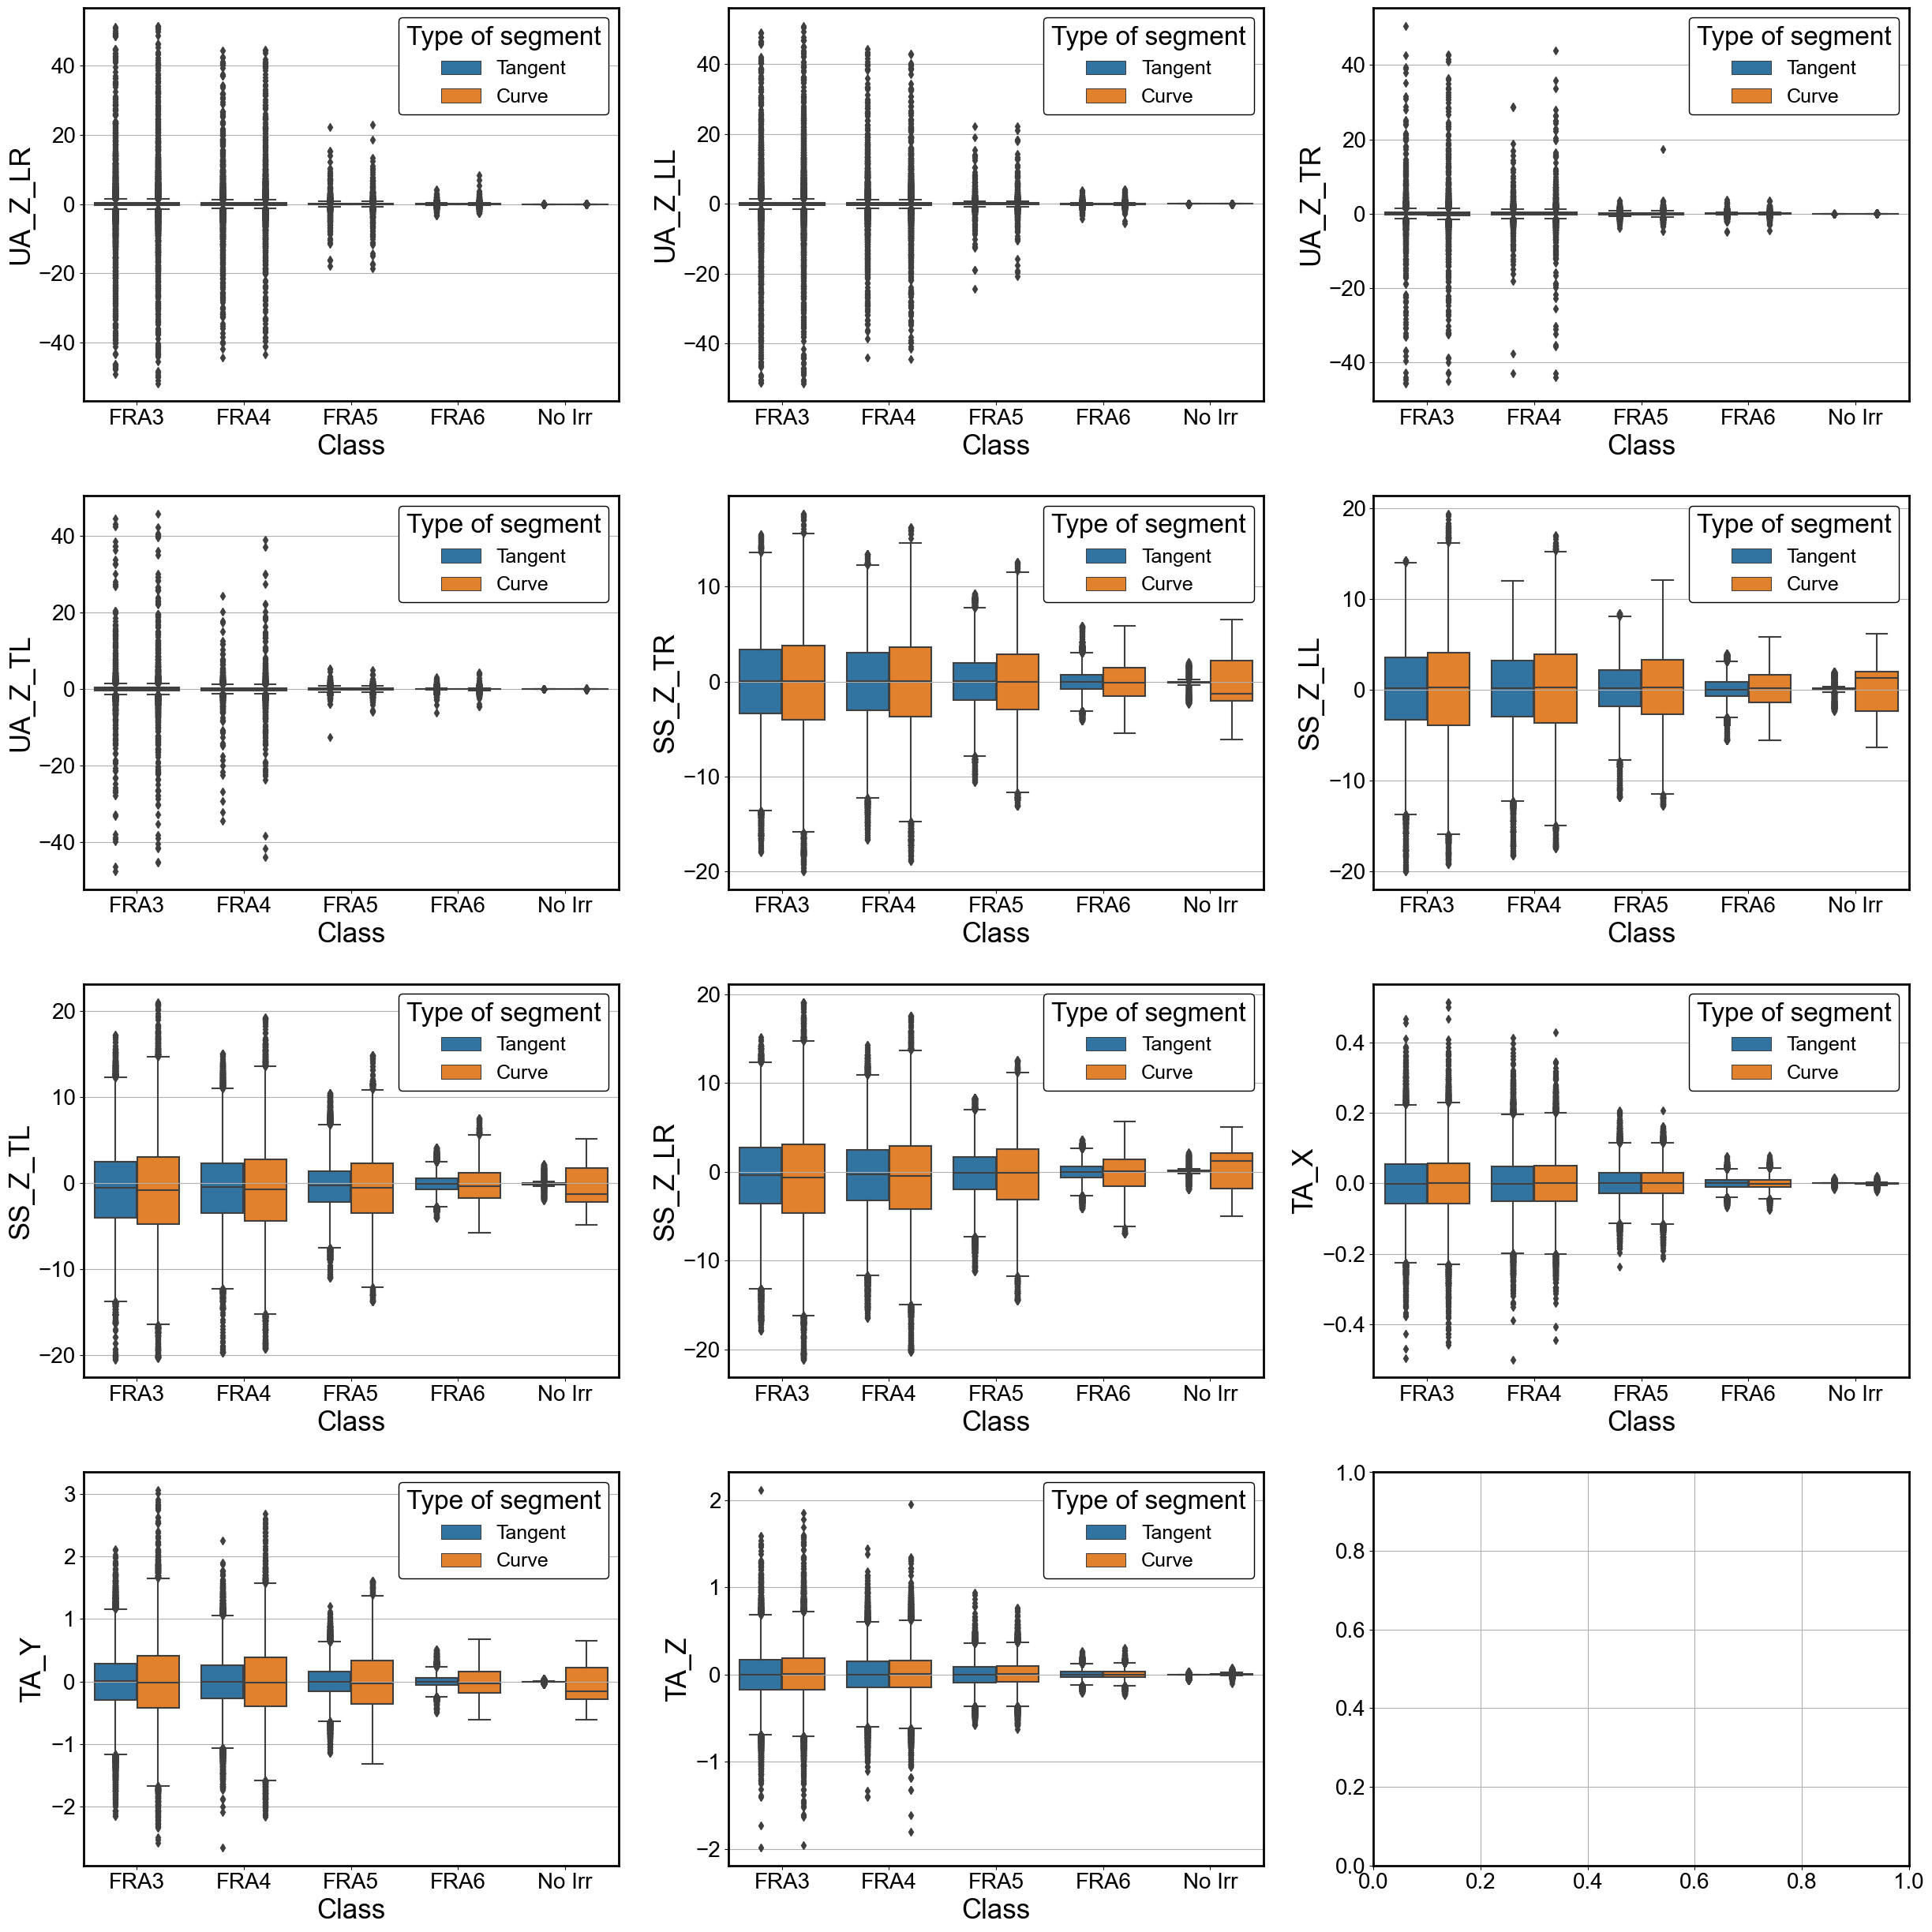

In [ ]:
fig, ax = boxplot_sensors(df_removed, x='Class', columns=numerical_columns, n_cols=3, figsize=(25, 25), hue='Type of segment',
                      order=['FRA3', 'FRA4', 'FRA5', 'FRA6', 'No Irr'])

#fig.savefig('Images/boxplots_after_outlier_removal.png', dpi=500,bbox_inches='tight', facecolor='white', transparent=False)

**No irregularities**

-  There is a clear difference between curves sections and tangent sections for most sensors

**FRA classes**

- For the suspension sensors, it is possible to distinguish curved section from a tangent section;
- Larger irregularities makes it harder to distinguish curved sections from tangent sections. Specifically, FRA6 and FRA5 are more easily distinguishable compared to FRA4 and FRA3

In [ ]:
df_filtered = df_removed.loc[(df['Class'] == 'FRA3') | (df['Class'] == 'FRA6') | (df['Class'] == 'No irregularities')]

# fig,ax = lineplot_sensors(df_filtered, x='Distance',columns=numerical_columns, n_cols=2, figsize=(30, 40), hue='Class', hue_order=['FRA3','FRA6','No irregularities'])

# sns.lineplot(data=df_filtered, x='Distance', y='Triaxial_y',ax=ax[-1], hue='Class', hue_order=['FRA3', 'FRA6', 'No irregularities'])
# ax[-1].set_xlim([4100,4800])
# ax[-1].set_ylim([-2, 3.2])

In [ ]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 24,
    'axes.edgecolor': 'black',
    'axes.labelsize': 22,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'font.family': 'Arial',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

Text(0.5, 0, 'Distance (m)')

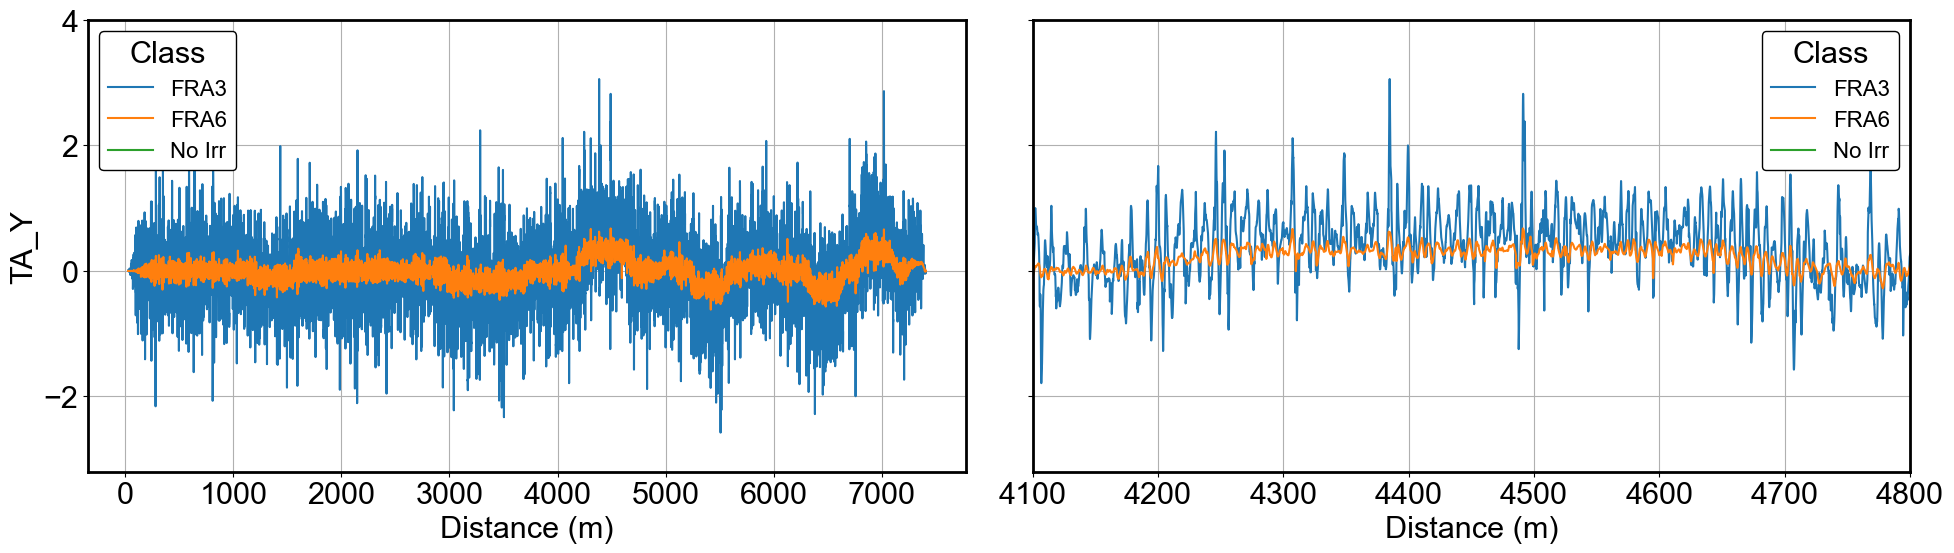

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6), tight_layout=True, sharey=True)


sns.lineplot(data=df_filtered, x='Distance', y='TA_Y',ax=ax[0], hue='Class', hue_order=['FRA3', 'FRA6', 'No Irr'])
ax[0].set_ylim([-3.2, 4])
ax[0].set_xlabel('Distance (m)')

sns.lineplot(data=df_filtered, x='Distance', y='TA_Y',ax=ax[1], hue='Class', hue_order=['FRA3', 'FRA6', 'No Irr'])
ax[-1].set_xlim([4100, 4800])
ax[-1].set_ylim([-3.2, 4])
ax[-1].set_xlabel('Distance (m)')

In [ ]:
# df_aux = df_removed.loc[(df_removed['Distance'] < 4700) & (df_removed['Distance'] > 4200)]

# fig = px.line(df_aux, x="Distance", y='Triaxial_y', color="Class")

# fig.update_layout(
#     autosize=False,
#     width=1200,
#     height=600)

# fig.show()
# pyst.plot(fig, filename='triaxial_y', auto_open=True)

The presence of track irregularities masks the effect the curvature has on the signal, making it harder to distinguish a curved section from a tangent section. It is still possible, only more difficult

# Difference between classes of irregularity and signal values

In [ ]:
# fig,ax = boxplot_sensors(df_removed, x='Type of segment', columns=numerical_columns,n_cols=4, figsize=(30, 22), hue='Class')

-There is some difference between classes of irregularity:

- No irregularity, FRA 6 and FRA 5 are easily distinguishable for all sensor groups
- Distinguising between FRA 3 and FRA 4 is more challenging. This is due to the small difference between the irregularity signals. 

# The effect of radius on measured signals

In [ ]:
#fig, ax = boxplot_sensors(df_removed, x='Class',columns=numerical_columns, n_cols=2, figsize=(30, 50), hue='Radius class')

In [ ]:
# fig, ax = boxplot_sensors(df_removed, x='Class', columns=numerical_columns,n_cols=2, figsize=(30, 40), hue='Radius')

**Conclusions**

- Radius class does not affect the uniaxial accelerometer signal and the Z and X components of the triaxial accelerometer
- Radius class affects the Y component of the triaxial accelerometer and all suspension sensors


# Correlation between input data and target variable for numerical variables

## Univariate correlation

In [ ]:
df_corr = df_removed.drop(['Distance','Curvature','Radius class','Radius'],axis=1)

# dual_heat_map(df_corr,figsize=(25,15))

In [ ]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 20,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 22,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'font.family': 'Arial',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

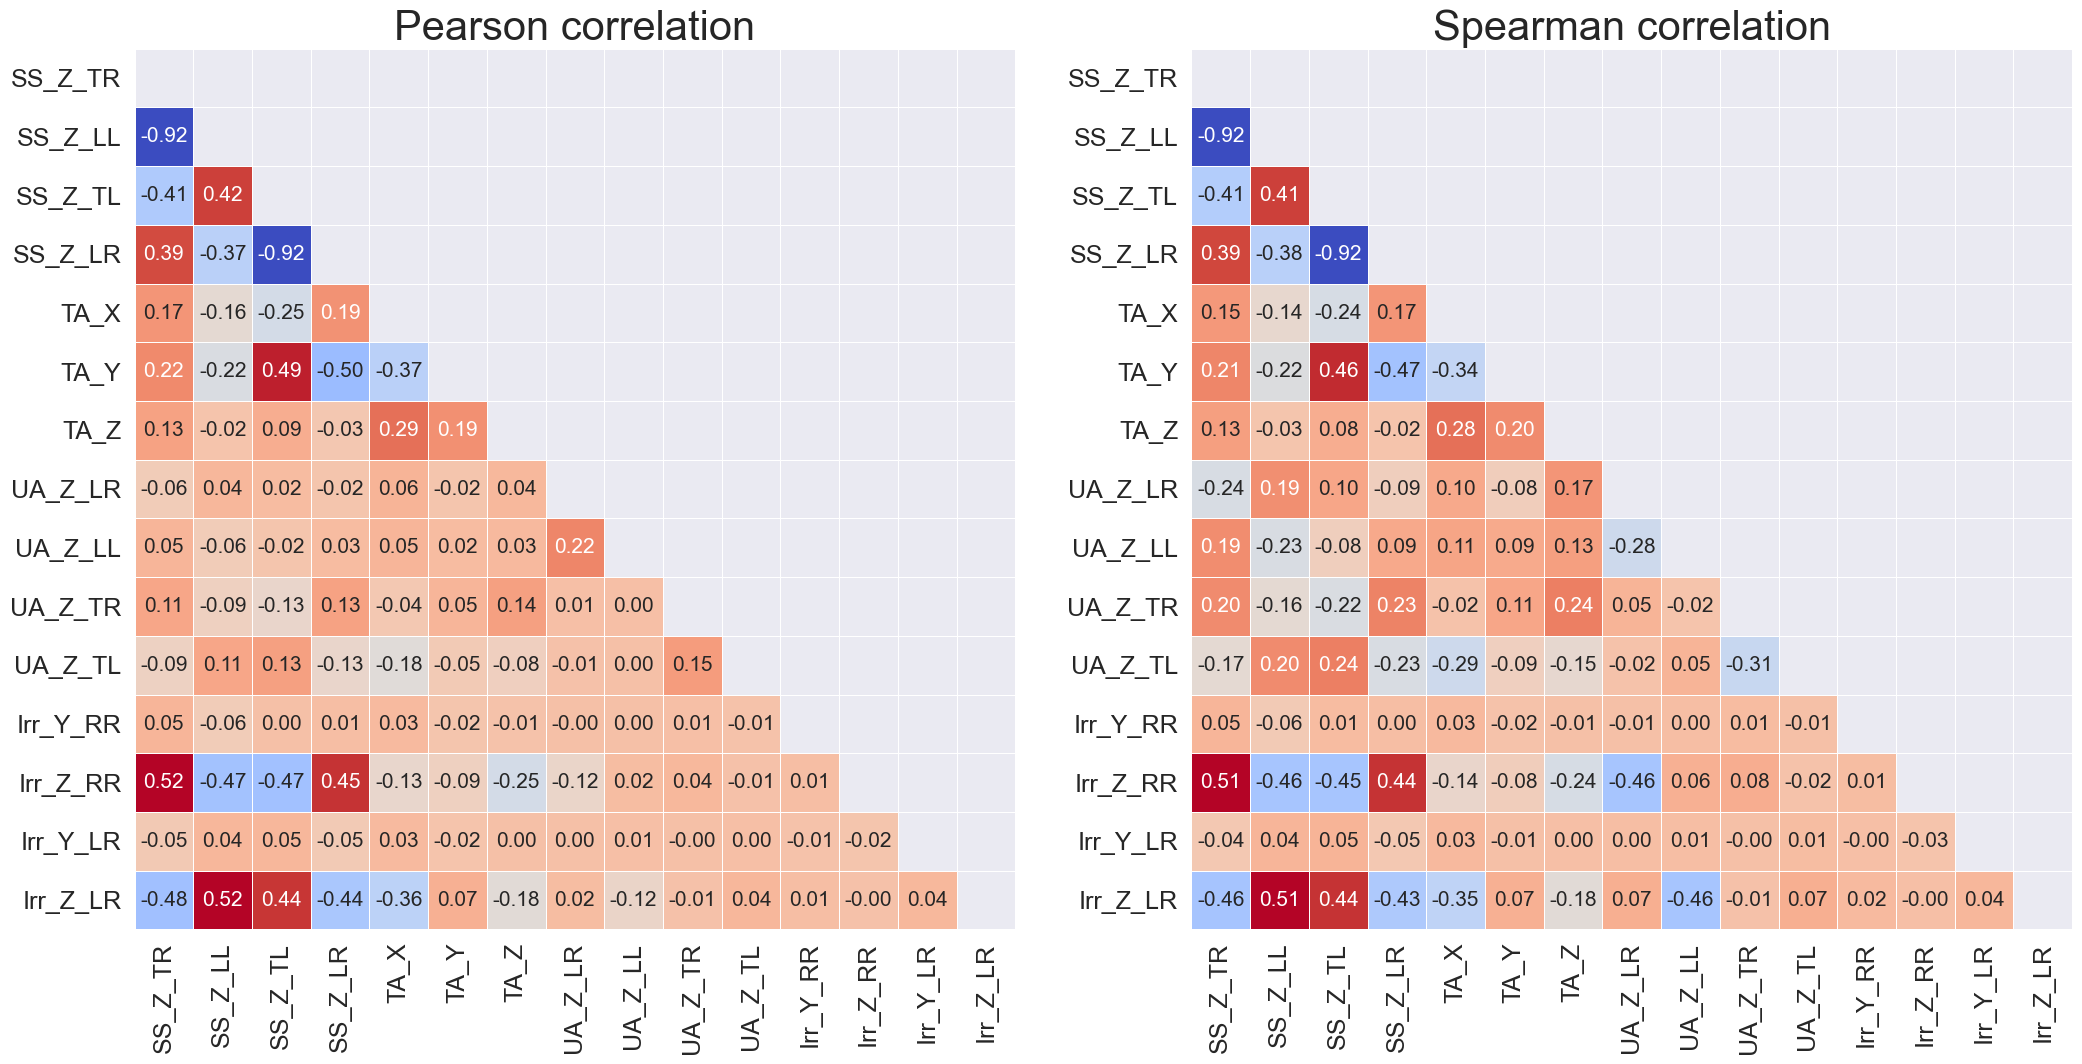

In [ ]:
df_filtered = df_corr.loc[(df['Class'] == 'FRA4')]

dual_heat_map(df_filtered, figsize=(25, 15),scale=2.5)

In [ ]:
# df_filtered = df_corr.loc[(df['Class'] == 'FRA6')]

# dual_heat_map(df_filtered, figsize=(25, 15))

In [ ]:
# pps_heat_map(df, figsize=(30,15))

**Conclusions**

- No univariate correlation is found between the lateral irregularities and the real measured variables. This suggests that the current IRV instrumentation is insufficient for this type of measurement
- Vertical irregularities has some correlation between the suspension sensors and the uniaxial accelerometers of the leading bogie. This suggests that placing sensors on the leading bogie is better for detecting this phenomena. 
- Surprisingly, triaxial_x has some correlation with the vertical irregularity.
- The categorical columns contain redundant information (PPScore). Therefore, only the column 'Type of segment' will be used
- **The current measured variables have no univariate correlation with the lateral track irregularities.**
- **The current measured variables have some univariate correlation with the vertical track irregularities.**

Therefore, this work will focus on vertical track irregularities

# Visualizing the correlation coefficient in scatterplots

In [ ]:
x_vars = triaxial
#y_vars = ['Vert_irreg_right_rail']
y_vars = ['Irr_Z_RR']

In [ ]:
# scatterplot_pearson(df,x_vars,y_vars, cmap='Set1')

# x_vars = susp_sensors
# scatterplot_pearson(df,x_vars,y_vars, cmap='Set1')

# x_vars = uni_accel
# scatterplot_pearson(df,x_vars,y_vars, cmap='Set1')

In [ ]:
#df_filtered = df_removed.loc[(df['Class']=='FRA6') | (df['Class']=='FRA3')]


# x_vars = triaxial
# scatterplot_pearson(df_filtered,x_vars,y_vars, cmap='Set1')

# x_vars = susp_sensors
# scatterplot_pearson(df_filtered,x_vars,y_vars, cmap='Set1')

# x_vars = uni_accel
# scatterplot_pearson(df_filtered,x_vars,y_vars, cmap='Set1')


In [ ]:
# df_filtered = df_removed.loc[(df['Class']=='FRA3')]

# x_vars = triaxial
# scatterplot_pearson(df_filtered,x_vars,y_vars, cmap='Set1')

# x_vars = susp_sensors
# scatterplot_pearson(df_filtered,x_vars,y_vars, cmap='Set1')

# x_vars = uni_accel
# scatterplot_pearson(df_filtered,x_vars,y_vars, cmap='Set1')

# Distribution of target variable 

In [ ]:
cols_irreg

['Irr_Y_RR', 'Irr_V_RR', 'Irr_Y_LR', 'Irr_Z_LR']

In [ ]:
#cols_irreg = ['Lat_irreg_right_rail','Vert_irreg_right_rail','Lat_irreg_left_rail','Vert_irreg_left_rail','Class']
cols_irreg = ['Irr_Y_RR', 'Irr_Z_RR', 'Irr_Y_LR', 'Irr_Z_LR','Class']
df_filtered = df_removed.loc[(df['Class'] != 'No Irr')]

In [ ]:
import matplotlib

plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 22,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'font.family': 'Arial',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})


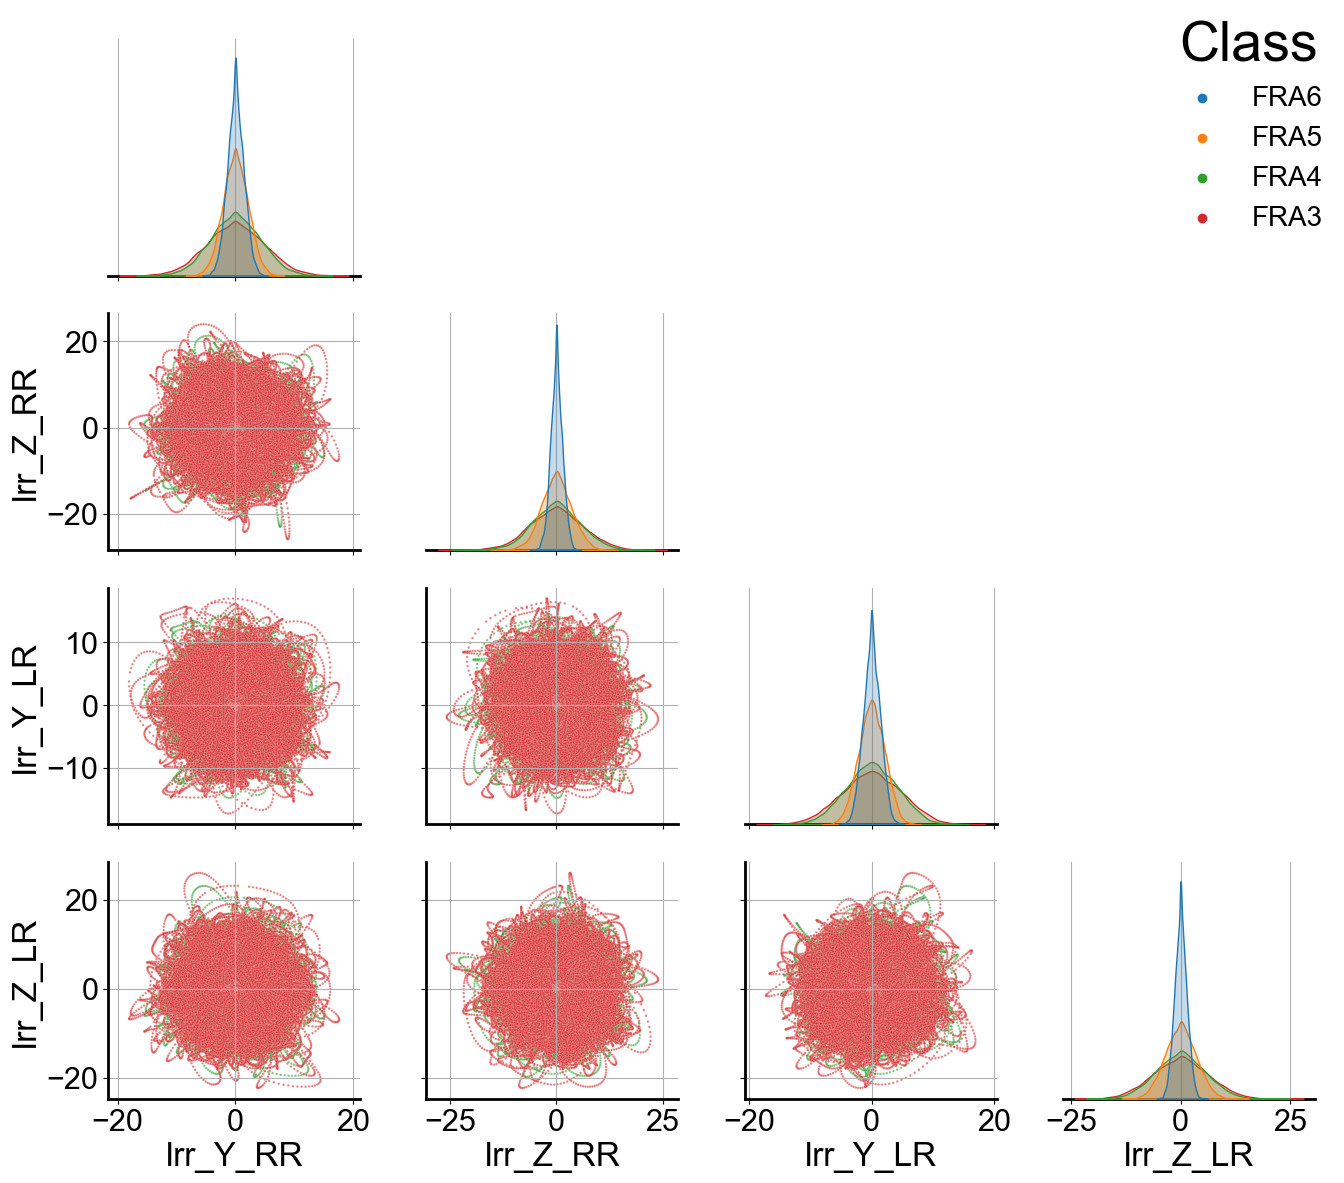

In [ ]:
g = sns.PairGrid(df_filtered[cols_irreg], hue="Class", corner=True, height=3, aspect=1, layout_pad=0.6)

g.map_diag(sns.kdeplot,shade=True)
g.map_lower(sns.scatterplot,s=3,alpha=0.6)
g.add_legend(fontsize=20, bbox_to_anchor=(1, 0.9))

plt.setp(g._legend.get_title(), fontsize='40')  # for legend title
plt.tight_layout()

Looks like we will have an unbalanced dataset, where the grand majority are small irregularities. We want to be capable of measuring both small and large irregularities, therefore, we must balance the dataset and have the classes that our railway is accustomed to working with (FRA5-FRA4). 

In [ ]:
# df_filtered = df_removed.loc[(df['Class'] == 'FRA4')]

# g = sns.PairGrid(df_filtered[cols_irreg], hue="Class",corner=True,height=4,aspect=1)
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot,s=3,alpha=0.6)
# g.add_legend()
# plt.tight_layout()

Now the dataset has a good balance of small irregularities and large irregularities to predict. The BRA railway quality typically oscillates between FRA4 and FRA5

# Final dataset

In [ ]:
# cols = ['Distance','Trail_right_z_sec_susp', 'Lead_left_z_sec_susp', 'Trail_left_z_sec_susp', 'Lead_right_z_sec_susp','Triaxial_x', 'Triaxial_y', 'Triaxial_z',
# 'Lead_z_accel_right_side', 'Lead_z_accel_left_side', 'Trail_z_accel_right_side', 'Trail_z_accel_left_side',
# 'Vert_irreg_right_rail']

cols = ['Distance', 
                'SS_Z_TR', 'SS_Z_LL', 'SS_Z_TL', 'SS_Z_LR',
                'TA_X', 'TA_Y', 'TA_Z',
                'UA_Z_LR', 'UA_Z_LL', 'UA_Z_TR', 'UA_Z_TL',
                'Irr_Z_RR'
                ]


#df_filtered = df_removed.loc[(df['Class'] == 'FRA3') | (df['Class'] == 'FRA4') | (df['Class'] == 'FRA5')]
df_filtered = df_removed.loc[(df['Class'] == 'FRA4')]
df = df_filtered[cols]
df

,Distance,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Y,TA_Z,UA_Z_LR,UA_Z_LL,UA_Z_TR,UA_Z_TL,Irr_Z_RR
205056,25.0472,0.000414,0.000265,0.000098,-0.000025,0.000003,-0.000055,0.000002,-0.000004,0.000047,0.000003,-0.000002,-0.002830
205057,25.1552,0.000443,0.000308,0.000110,-0.000030,0.000003,-0.000054,0.000004,0.000001,0.000050,0.000003,-0.000002,-0.002450
205058,25.2632,0.000471,0.000350,0.000123,-0.000035,0.000004,-0.000053,0.000006,0.000007,0.000053,0.000002,-0.000002,-0.001960
205059,25.3712,0.000500,0.000393,0.000135,-0.000041,0.000004,-0.000051,0.000007,0.000013,0.000057,0.000002,-0.000002,-0.001350
205060,25.4792,0.000529,0.000435,0.000147,-0.000046,0.000004,-0.000050,0.000009,0.000019,0.000060,0.000002,-0.000002,-0.000653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
273403,7406.5210,-0.111903,-0.231038,0.133286,0.050300,0.001834,-0.017724,0.000079,0.004336,0.001357,0.027580,-0.002892,0.048600
273404,7406.6290,-0.113222,-0.225703,0.140285,0.042200,0.001846,-0.017451,-0.000082,0.003567,0.000598,0.025054,-0.000514,0.051100
273405,7406.7380,-0.114092,-0.220937,0.148758,0.034700,0.001823,-0.017368,-0.000321,0.002644,-0.000098,0.023842,0.002592,0.053500
273406,7406.8460,-0.114961,-0.216170,0.157232,0.027200,0.001800,-0.017286,-0.000559,0.001721,-0.000794,0.022632,0.005697,0.055800


In [ ]:
#df_final.to_csv('Processed_data/FRA3-FRA6_cleaned.csv.zip',index=False, compression="zip")
df.to_csv('Processed_data/FRA3-FRA6_cleaned.csv.zip',index=False, compression="zip")